In [147]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score,  precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

In [149]:
# 1. Data preparation

In [151]:
# 1.1 Load the dataset

# The downloaded dataset was split into train and test data. The train data was used in model selection, training and
# evaluation. The model was trained by using k fold cross validation (number of folds=3). The model accuracy was improved with hyperparameter tuning. The 
# trained model was used to predict loan approval for the test data.

In [153]:
loan_features = pd.read_csv("C:/Users/61450/Desktop/New folder/loan approval/loan features.csv")
loan_target = pd.read_csv("C:/Users/61450/Desktop/New folder/loan approval/loan target.csv")
loan_data  = pd.concat([loan_features, loan_target], ignore_index=False, axis=1)
loan_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Target
0,LP001032,Male,No,0,Graduate,No,4950,0.0,125,360,1,Urban,Y
1,LP001824,Male,Yes,1,Graduate,No,2882,1843.0,123,480,1,Semiurban,Y
2,LP002928,Male,Yes,0,Graduate,No,3000,3416.0,56,180,1,Semiurban,Y
3,LP001814,Male,Yes,2,Graduate,No,9703,0.0,112,360,1,Urban,Y
4,LP002244,Male,Yes,0,Graduate,No,2333,2417.0,136,360,1,Urban,Y


In [155]:
# 1.2 Data Explortion

In [157]:
print('Percentage frequency of labelled responses of the target variable', loan_data['Target'].value_counts()/ len(loan_data['Target']))

Percentage frequency of labelled responses of the target variable Target
Y    0.691667
N    0.308333
Name: count, dtype: float64


In [159]:
# The target variable is imbalanced with nearly 70% of labelled responses showing loan approvals.

In [161]:
loan_data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Target               0
dtype: int64

In [163]:
# 1.3 Data preprocessing

In [165]:
loan_data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount             int64
Loan_Amount_Term       int64
Credit_History         int64
Property_Area         object
Target                object
dtype: object

In [167]:
# Encode categorical variables (Gender, Married, Dependents, Education, Self employed, property area and target variable)

# Encode Gender, Married, Education, Self employed and Target using label encoder)

label_encoder = preprocessing.LabelEncoder()
loan_data['Gender'] = label_encoder.fit_transform(loan_data['Gender'])
loan_data['Married'] = label_encoder.fit_transform(loan_data['Married'])
loan_data['Education'] = label_encoder.fit_transform(loan_data['Education'])
loan_data['Self_Employed'] = label_encoder.fit_transform(loan_data['Self_Employed'])
loan_data['Target'] = label_encoder.fit_transform(loan_data['Target'])
loan_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Target
0,LP001032,1,0,0,0,0,4950,0.0,125,360,1,Urban,1
1,LP001824,1,1,1,0,0,2882,1843.0,123,480,1,Semiurban,1
2,LP002928,1,1,0,0,0,3000,3416.0,56,180,1,Semiurban,1
3,LP001814,1,1,2,0,0,9703,0.0,112,360,1,Urban,1
4,LP002244,1,1,0,0,0,2333,2417.0,136,360,1,Urban,1


In [169]:
# Encode 'property area' using one hot encoder

one_hot = preprocessing.OneHotEncoder(sparse_output=False)
loan_property = np.array(loan_data['Property_Area']).reshape(len(loan_data['Property_Area']),1)
one_hot_encode = one_hot.fit_transform(loan_property)
one_hot = pd.DataFrame(one_hot_encode, columns=sorted(list(loan_data['Property_Area'].unique())))
loan_data_1 = pd.concat([loan_data.drop('Property_Area', axis=1), one_hot], axis=1)

In [185]:
# Encode 'Dependents' using one hot encoder

loan_data_1['Dependents'] = loan_data_1['Dependents'].astype(str)

loan_data_1['Dependents'] = loan_data_1['Dependents'].map({'0': '0 dependent', '1':'1 dependent', 
'2':'2 dependents', '3+': 'more than 3 dependents'})

one_hot = preprocessing.OneHotEncoder(sparse_output=False)
loan_dependent = np.array(loan_data_1['Dependents']).reshape(len(loan_data_1['Dependents']),1)
one_hot_encode = one_hot.fit_transform(loan_dependent)
one_hot = pd.DataFrame(one_hot_encode, columns=sorted(list(loan_data_1['Dependents'].unique())))
loan_approval_data = pd.concat([loan_data_1.drop('Dependents', axis=1), one_hot], axis=1)

In [187]:
loan_approval_data.head()

,Loan_ID,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Target,Rural,Semiurban,Urban,0 dependent,1 dependent,2 dependents,more than 3 dependents
0,LP001032,1,0,0,0,4950,0.0,125,360,1,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,LP001824,1,1,0,0,2882,1843.0,123,480,1,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,LP002928,1,1,0,0,3000,3416.0,56,180,1,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,LP001814,1,1,0,0,9703,0.0,112,360,1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,LP002244,1,1,0,0,2333,2417.0,136,360,1,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [25]:
# 1.4 Feature engineering

In [189]:
# Create column of the ratio of loan amount to applicant income 

loan_approval_data['debt_to_appincome'] = loan_approval_data['LoanAmount']*1000/loan_approval_data['ApplicantIncome']

In [191]:
# Create column of the ratio of loan amount to the sum of applicant income and co-applicant income

loan_approval_data['debt_to_totalincome'] = loan_approval_data['LoanAmount']*1000/(loan_approval_data['ApplicantIncome']+loan_approval_data['CoapplicantIncome'])

In [193]:
loan_approval_data['LoanAmount'] = loan_approval_data['LoanAmount'] *1000

In [195]:
# 1.5 Normalizaiton of numerical features

In [197]:
normalized_data_appincome = MinMaxScaler().fit_transform(np.array(loan_approval_data['ApplicantIncome']).reshape(len(loan_approval_data['ApplicantIncome']),1))
normalized_data_coappincome = MinMaxScaler().fit_transform(np.array(loan_approval_data['CoapplicantIncome']).reshape(len(loan_approval_data['CoapplicantIncome']),1))
normalized_data_loanamt = MinMaxScaler().fit_transform(np.array(loan_approval_data['LoanAmount']).reshape(len(loan_approval_data['LoanAmount']),1))
normalized_data_debtin = MinMaxScaler().fit_transform(np.array(loan_approval_data['debt_to_appincome']).reshape(len(loan_approval_data['debt_to_appincome']),1))
normalized_data_debttotalinc = MinMaxScaler().fit_transform(np.array(loan_approval_data['debt_to_totalincome']).reshape(len(loan_approval_data['debt_to_totalincome']),1))
normalized_data_loanterm = MinMaxScaler().fit_transform(np.array(loan_approval_data['Loan_Amount_Term']).reshape(len(loan_approval_data['Loan_Amount_Term']),1))

In [199]:
scaled_data1 = pd.DataFrame(normalized_data_appincome, columns=['ApplicantIncome'])
scaled_data2 = pd.DataFrame(normalized_data_coappincome, columns=['CoapplicantIncome'])
scaled_data3 = pd.DataFrame(normalized_data_loanamt, columns=['LoanAmount'])
scaled_data4 = pd.DataFrame(normalized_data_debtin, columns=['debt_to_appincome'])
scaled_data5 = pd.DataFrame(normalized_data_debttotalinc, columns=['debt_to_totalincome'])
scaled_data6 = pd.DataFrame(normalized_data_loanterm, columns=['Loan_Amount_Term'])

In [201]:
loan_data = pd.concat([loan_approval_data.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount', 'debt_to_appincome','debt_to_totalincome','Loan_Amount_Term'],axis=1),scaled_data1,scaled_data2,scaled_data3,scaled_data4,scaled_data5,scaled_data6], axis=1)

In [203]:
loan_data.head()

,Loan_ID,Gender,Married,Education,Self_Employed,Credit_History,Target,Rural,Semiurban,Urban,0 dependent,1 dependent,2 dependents,more than 3 dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,debt_to_appincome,debt_to_totalincome,Loan_Amount_Term
0,LP001032,1,0,0,0,1,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.059369,0.000000,0.196277,0.024790,0.283451,0.729730
1,LP001824,1,1,0,0,1,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.033791,0.054467,0.192893,0.044218,0.293169,1.000000
2,LP002928,1,1,0,0,1,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.035250,0.100955,0.079526,0.017448,0.077383,0.324324
3,LP001814,1,1,0,0,1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.118157,0.000000,0.174281,0.009506,0.112483,0.729730
4,LP002244,1,1,0,0,1,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.027001,0.071431,0.214890,0.061626,0.325590,0.729730


In [205]:
# 1.6 Split data int train and test data

In [207]:
# The imbalance in target variable is handled by equal distribution in the proportion of positve and negative labels to train and test data.

x_train, x_test, y_train, y_test = train_test_split(loan_data.drop(['Target','Loan_ID'], axis=1), loan_data['Target'], test_size=0.3, random_state=32, stratify=loan_data['Target'])

print('Percentage frequency of labelled responses of the train data')
print(y_train.value_counts()/ len(y_train))
print('Percentage frequency of labelled responses of the test data')
print(y_test.value_counts()/ len(y_test))

Percentage frequency of labelled responses of the train data
Target
1    0.690476
0    0.309524
Name: count, dtype: float64
Percentage frequency of labelled responses of the test data
Target
1    0.694444
0    0.305556
Name: count, dtype: float64


In [209]:
#2. Model building and training 

In [211]:
# Use Gradient boosting classifier  XGBoost for predicting loan approvals
# !pip install xgboost

In [213]:
xgbclas = XGBClassifier(objective='binary:logistic', tree_method='auto', eval_metric='auc', enable_categorical=True)

# Choose different combinations of hyperparameters. Hyperparameter tuning using 3 fold cross validation

param = {'max_depth' : [1,3,4,5], 'subsample':[0.1,0.4,0.7,1], 'colsample_bytree':[0.4,0.6,0.7,1], 'learning_rate':[0.01,0.1,0.3,0.6],'n_estimators':[50,100,200]}
grid_cv = GridSearchCV(estimator=xgbclas, param_grid=param, return_train_score=True, n_jobs=4, scoring='roc_auc', verbose=1, cv=3)

# Train the model 
grid_cv.fit(x_train, y_train)

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric='auc',
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.4, 0.6, 0.7, 1],
                         'learning_rate': [0.01, 0.1, 0.3, 0.6],
                         'max_depth': [1, 3, 4, 5],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.1, 0.4, 0.7, 1]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [215]:
# Choose the best parameters for predictions

grid_cv_par = grid_cv.best_params_

In [217]:
grid_cv_par

{'colsample_bytree': 0.6,
 'learning_rate': 0.3,
 'max_depth': 1,
 'n_estimators': 50,
 'subsample': 0.7}

In [77]:
# Fit the model with the chosen hyperparameters to the train data
# Use the trained model to predict the probability of loan approval on the test data

In [219]:
xgb_cl = XGBClassifier(objective='binary:logistic', tree_method='auto', eval_metric='auc', enable_categorical=True, colsample_bytree=0.6, 
                       learning_rate=0.3, max_depth=1, n_estimators=50, subsample=0.7)

xgb_cl.fit(x_train, y_train)

pred_prob_xtrain = xgb_cl.predict_proba(x_train)
pred_prob_xtest = xgb_cl.predict_proba(x_test)

In [221]:
# Plot the calibration curve between true and predicted probabilities

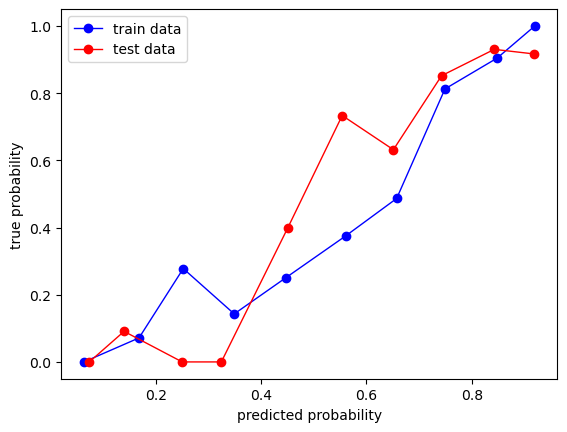

In [223]:
true_pos_tr, pred_pos_tr = calibration_curve(y_train, pred_prob_xtrain[:,1], n_bins=10)
true_pos_test, pred_pos_test = calibration_curve(y_test, pred_prob_xtest[:,1], n_bins=10)

#Plot the Probabilities Calibrated curve
plt.plot(pred_pos_tr, true_pos_tr, marker='o', color='blue', linewidth=1, label='train data')
plt.plot(pred_pos_test, true_pos_test, marker='o', color='red',  linewidth=1, label='test data')
plt.xlabel('predicted probability')
plt.ylabel('true probability')
plt.legend(loc='upper left')

In [225]:
# Performance evaluation using performance metrics

In [227]:
pred_xtrain = xgb_cl.predict(x_train)
pred_xtest = xgb_cl.predict(x_test)

In [229]:
print('accuracy score of train data is {0:.2f}'.format(accuracy_score(y_train, pred_xtrain)))
print('accuracy score of test data is {0:.2f}'.format(accuracy_score(y_test, pred_xtest)))

accuracy score of train data is 0.81
accuracy score of test data is 0.85


In [231]:
print('confusion matrix of train data')
print(pd.crosstab(y_train, pred_xtrain, rownames=['actual'], colnames=['predicted']))
print('\n')
print('confusion matrix of test data')
print(pd.crosstab(y_test, pred_xtest, rownames=['actual'], colnames=['predicted']))

confusion matrix of train data
predicted   0    1
actual            
0          49   55
1          10  222


confusion matrix of test data
predicted   0   1
actual           
0          25  19
1           3  97


In [233]:
print('precision score of train data is {0:.2f}'.format(precision_score(y_train, pred_xtrain)))
print('precision score of test data is {0:.2f}'.format(precision_score(y_test, pred_xtest)))

precision score of train data is 0.80
precision score of test data is 0.84


In [235]:
print('recall score of train data is {0:.2f}'.format(recall_score(y_train, pred_xtrain)))
print('recall score of test data is {0:.2f}'.format(recall_score(y_test, pred_xtest)))

recall score of train data is 0.96
recall score of test data is 0.97


In [237]:
print('f1 score of train data is {0:.2f}'.format(f1_score(y_train, pred_xtrain)))
print('f1 score of test data is {0:.2f}'.format(f1_score(y_test, pred_xtest)))

f1 score of train data is 0.87
f1 score of test data is 0.90


In [239]:
print('roc auc score of train data is {0:.2f}'.format(roc_auc_score(y_train, pred_xtrain)))
print('roc auc score of test data is {0:.2f}'.format(roc_auc_score(y_test, pred_xtest)))

roc auc score of train data is 0.71
roc auc score of test data is 0.77


In [241]:
print('classification report of train data is')
print(classification_report(y_train, pred_xtrain))
print('classification report of test data is')
print(classification_report(y_test, pred_xtest))

classification report of train data is
              precision    recall  f1-score   support

           0       0.83      0.47      0.60       104
           1       0.80      0.96      0.87       232

    accuracy                           0.81       336
   macro avg       0.82      0.71      0.74       336
weighted avg       0.81      0.81      0.79       336

classification report of test data is
              precision    recall  f1-score   support

           0       0.89      0.57      0.69        44
           1       0.84      0.97      0.90       100

    accuracy                           0.85       144
   macro avg       0.86      0.77      0.80       144
weighted avg       0.85      0.85      0.84       144



In [243]:
fprate_tr, tprate_tr, thresholds = roc_curve(y_train, pred_xtrain)
roc_auc_train = auc(fprate_tr, tprate_tr)

fprate_test, tprate_test, thresholds = roc_curve(y_test, pred_xtest)
roc_auc_test = auc(fprate_test, tprate_test)

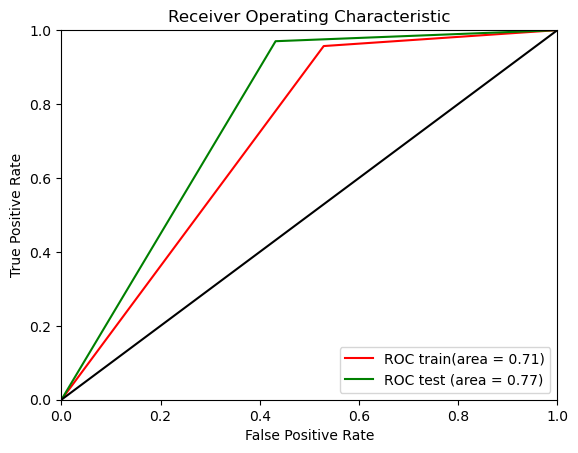

In [245]:
plt.figure()

plt.plot(fprate_tr, tprate_tr, color='red', label='ROC train(area = %0.2f)' % roc_auc_train)
plt.plot(fprate_test, tprate_test, color='green', label='ROC test (area = %0.2f)' % roc_auc_test)

plt.plot([0, 1], [0, 1], color='black')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

plt.legend(loc='lower right')

In [247]:
# Plot feature importance

In [249]:
feature_imp = dict(zip(loan_data.drop(['Target','Loan_ID'], axis=1).columns, xgb_cl.feature_importances_))
feature_sorted = pd.DataFrame(sorted(feature_imp.items(), key= lambda item:item[1], reverse=True))

<BarContainer object of 18 artists>

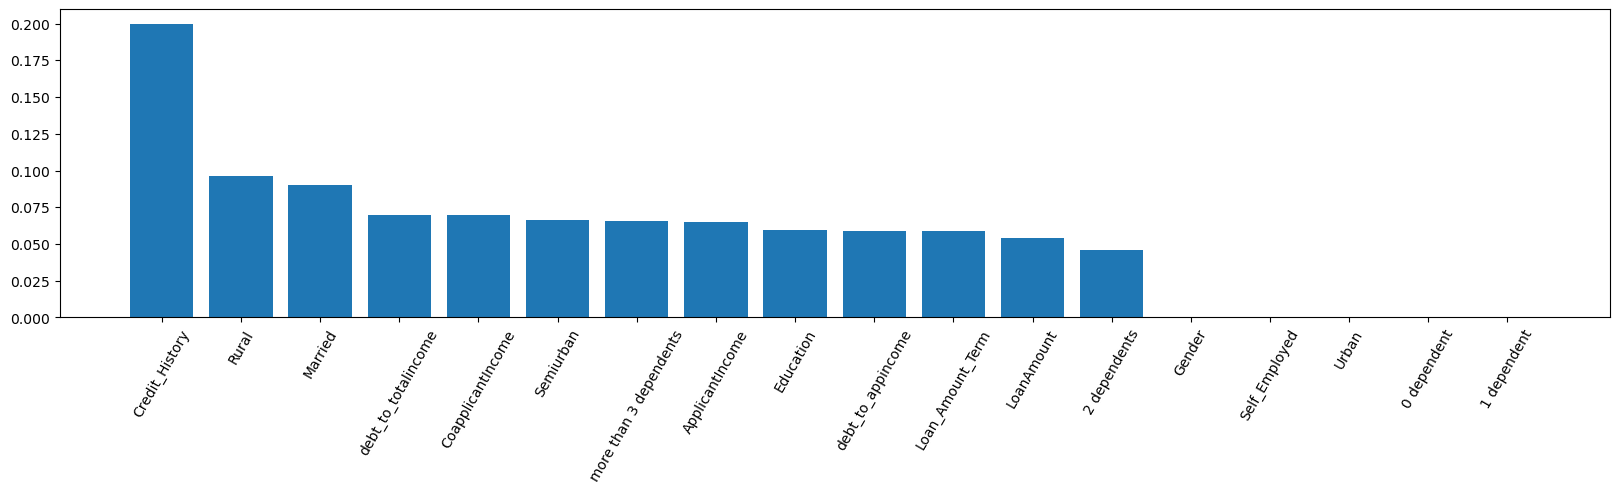

In [251]:
fig, ax = plt.subplots(figsize = (20, 4))
ax.set_xticks(ticks=range(18), labels=feature_sorted.iloc[:,0])
ax.set_xticklabels(labels=feature_sorted.iloc[:,0], rotation=60)
plt.bar(feature_sorted.iloc[:,0], feature_sorted.iloc[:,1])

In [ ]:
# Model insights

# The model accuracy was improved by observing roc auc score for different combinations of hyperparameters like colsample_bytree,
# learning_rate, max_depth, number of estimators and subsample ratio. The combination with the maximum auc score was used in fitting the model
# to the train data and predicting loan approvals of the test data. There is a trade off between learning rate and number of estimators. 
# Higher learning rate 0f 0.3 is balanced with only 50 estimators. 

# It is observed that the ability of the chosen model to discriminate between classes improves on test data. The accuracy score, precision, recall, f1 
# and roc auc scores of test data are higher than those of train data. However, the caveat is that the precision, recall and f1 scores are assumed 
# around the model's ability to correclty classify true positves. But the confusion matrices show  higher number of false positives as well than
# than true negatives. Hence, the recall scores for negative labels are 0.47 for train data and 0.57 for test data. Overall, the model
# performane is better for the test data than train data.
# It is likely that an imbalanced distribution of positives and negatives builds a model that misclassifies many loan application rejctions as approvals.

# Feature importance

# The above plot shows that the most important feature is credit history. The least important features are gender, whether the applicant is self employed,
# whether the applicant has 0 to 1 dependents and whether the property is in urban area or not. Other important features are marital status, applicant
# and co-applicant income, debt to applicant and total income ratios, semiurbana and rural area of the property, more than 3 dependents, loan amount
# and loan term. 

# It may be inferred that an applicant's credit history, property location, marital status, debt to total income and number of dependents should be 
# prioritised in loan approval decisions.